In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from os import listdir
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import cv2
import itertools


from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
from PIL import Image, ImageOps, ImageFilter, ImageEnhance

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.models import clone_model
# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  0


In [2]:
path = 'Images/'

In [3]:
df =  pd.read_csv('df_t.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"['features', 'elegance', 'polyester', 'multico...","['feature', 'elegance', 'polyester', 'multicol...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"['specifications', 'sathiyas', 'cotton', 'bath...","['specifications', 'sathiyas', 'cotton', 'bath...",specifications sathiyas cotton bath towel bath...,55


In [4]:
df.category.sort_values().unique()

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [5]:
df['category'].value_counts()

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [6]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [7]:
list_labels = df.category.sort_values().unique()

In [8]:
def list_products_by_category(category_name):
    return df[df['category'] == category_name]['image'].to_list()

In [9]:
from matplotlib.pyplot import imread

Baby Care


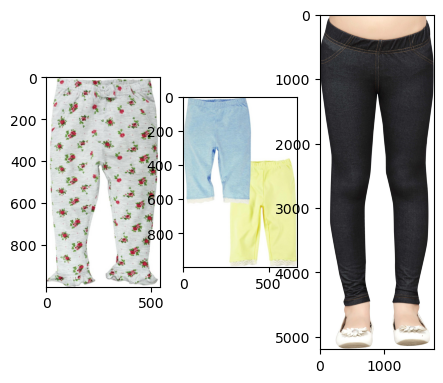

Beauty and Personal Care


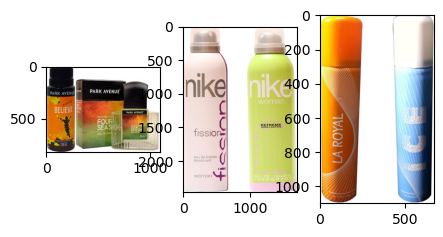

Computers


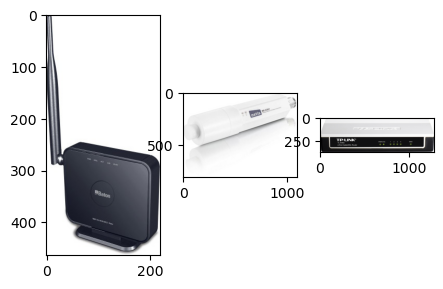

Home Decor & Festive Needs


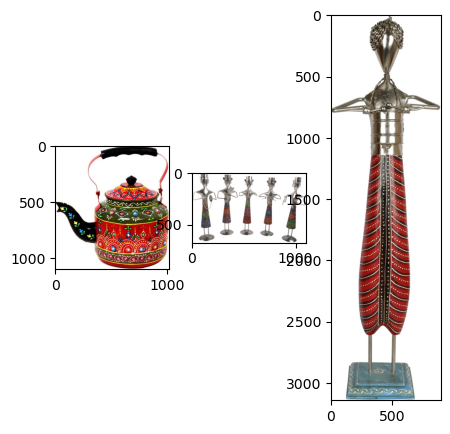

Home Furnishing


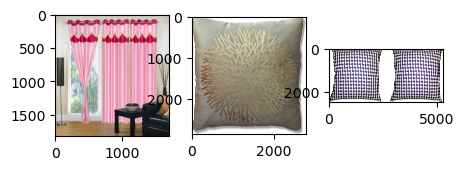

Kitchen & Dining


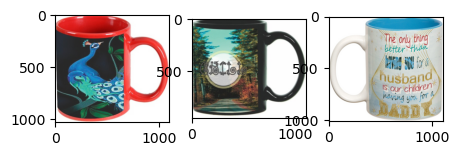

Watches


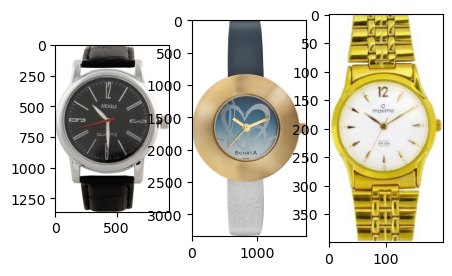

In [10]:
for name in list_labels:
    plt.figure(figsize=(5, 5))
    print(name)

    # Affichage de trois exemples d'images pour chaque catégorie
    for i in range(3):
        plt.subplot(130 + 1 + i)

        # Construire le chemin du fichier
        filename = os.path.join(path, list_products_by_category(name)[i + 42])
        image = imread(filename)
        # Displaying the image
        plt.imshow(image)

    plt.show()

In [11]:
# Creating  'list_photos' by extracting the 'image' column from the DataFrame df
list_photos = df['image'].to_list()

In [12]:
# Creating a new path for modified images
path_pro = 'Images_b/'

In [13]:
dir_read = path
dir_write = path_pro

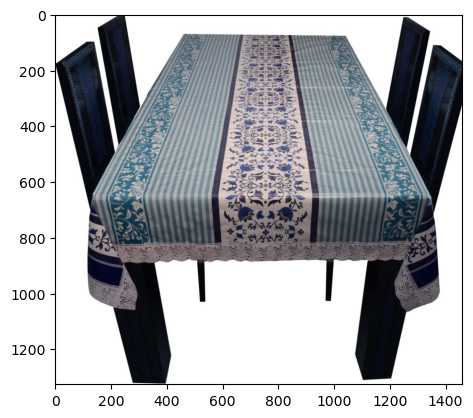

In [14]:
image_name = df['image'].loc[71]
dir_name = path
file_path = os.path.join(dir_name, image_name)

# Reading the file
image = cv2.imread(file_path)

# Displaying image
plt.imshow(image);

### Prétraitement des images

In [15]:
# Decompte du temps
temp = time.time()
# la taille des images
new_width = 250
new_height = 250
# Modifications des images
for index, row in df.iterrows():
    # obtenir la localisation l'image du produit
    img_name = row['image']
    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)
    # Read the file as a PIL Image
    img = Image.open(img_path)
    # Redimensionner les images
    img_resized = img.resize((new_width, new_height))
    # Conversion de l'image en niveaux de gris
    grayscale_image = img_resized.convert('L')
    # Égalisation
    equalized_image = ImageOps.equalize(grayscale_image)
    # Filtration du bruit
    blurred_image = equalized_image.filter(ImageFilter.GaussianBlur(radius=2))
    # Réglage du contraste
    contrast_enhancer = ImageEnhance.Contrast(blurred_image)
    contrast_enhanced_image = contrast_enhancer.enhance(1.5)
    # Enregistrez l'image prétraitée
    img_preprocessed_path = os.path.join(dir_write, img_name)
    contrast_enhanced_image.save(img_preprocessed_path)
# Calculer le temps de traitement
duree = time.time() - temp
print("Processing time: ", "%15.2f" % duree, "seconds")

Processing time:            49.06 seconds


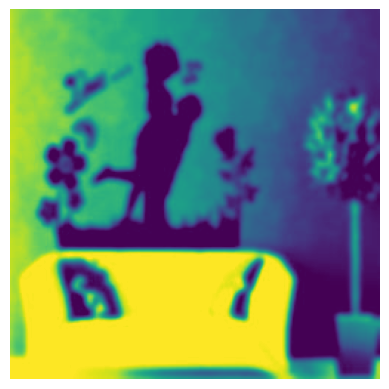

In [16]:
# Selecting an image to display
row_85 = df.iloc[85]

# Récupération de l'image
image_name = row_85['image']

# Construire le chemin vers l'image prétraitée
preprocessed_image_path = os.path.join(dir_write, image_name)

# Lire et afficher l'image prétraitée
preprocessed_image = Image.open(preprocessed_image_path)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

### SIFT

In [17]:
# Path to the directory containing preprocessed images
preprocessed_images_dir = dir_write
# Creating an array to store descriptors
descriptors_array = []
# Creation de l'Objet SIFT
sift = cv2.SIFT_create(500)
# Start the timer
temps0 = time.time()

# Iterating over each image in the directory
for img_name in os.listdir(preprocessed_images_dir):
    image_path = os.path.join(preprocessed_images_dir, img_name)
    img = Image.open(image_path)

    # Converting PIL Image to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Detecting keypoints and computing descriptors
    keypoints, descriptors = sift.detectAndCompute(img_cv, None)

    # Append descriptors to the array
    descriptors_array.append(descriptors)

# Concatenate all descriptors into a single array
descriptors_all = np.concatenate(descriptors_array, axis=0)

# Calculate the processing time
duree = time.time() - temps0
print("Processing time: ", "%15.2f" % duree, "seconds")

Processing time:            37.62 seconds


In [18]:
descriptors_all.shape

(171364, 128)

### K-means

In [19]:
from sklearn import cluster

In [20]:
k = len(list_labels)

print(f"Number of estimated clusters: {k}")

# Clustering all descriptors
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(descriptors_all)

Number of estimated clusters: 7


MiniBatchKMeans(init_size=21, n_clusters=7, random_state=0)

In [21]:
# Function to build histogram for an image
def build_histogram(kmeans, descriptors, img_name):
    res = kmeans.predict(descriptors)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(descriptors)
    if nb_des == 0:
        print("Image histogram problem: ", img_name)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# Creating a histogram matrix
hist_vectors = []

# Iterating over the descriptors for each image
for i, image_desc in enumerate(descriptors_array):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # Calculating the histogram
    hist_vectors.append(hist)  # Adding histogram to the list of histogram vectors

# Converting the list of histogram vectors to an array
im_features = np.asarray(hist_vectors)


0
100
200
300
400
500
600
700
800
900
1000


### Analyse des composantes principales : réduction de dimension

In [22]:
from sklearn.decomposition import PCA
print("Dataset dimensions before PCA reduction: ", im_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(im_features)

# Affichage de la taille du dataframe après reduction avec PCA
print("Dataset dimensions after PCA reduction: ", feat_pca.shape)

Dataset dimensions before PCA reduction:  (1050, 7)
Dataset dimensions after PCA reduction:  (1050, 6)


### T-sne  (Algorithme de réduction de dimension)

In [23]:
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init='random', random_state = 6)
X_tsne = tsne.fit_transform(feat_pca)

# Creatinf a new df for 2D visualisation
df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]

# Printing the shape of the new df
print(df_tsne.shape)

(1050, 3)


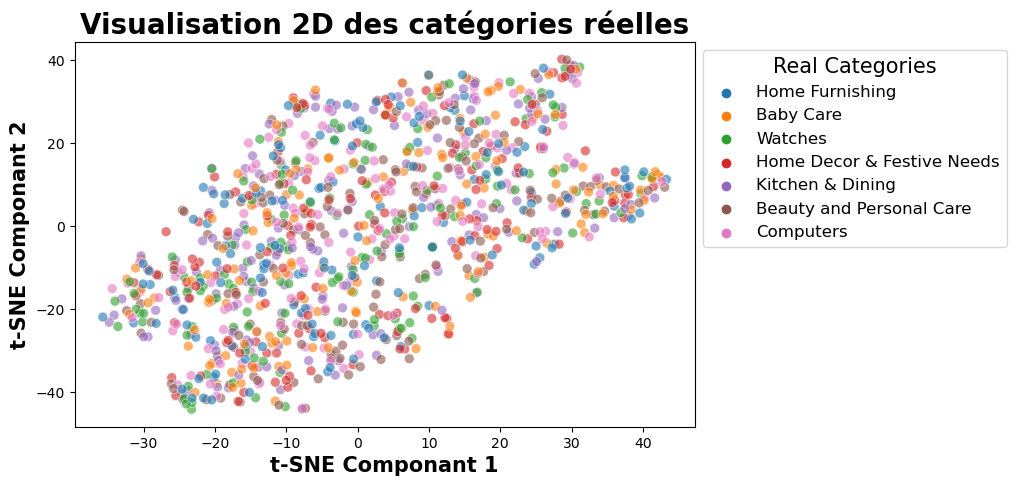

In [24]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x = "tsne1", y = "tsne2", hue = "class", data = df_tsne, legend = "brief",
    palette=sns.color_palette('tab10', n_colors = 7), s = 50, alpha = 0.6)
# Setting the details
plt.title("Visualisation 2D des catégories réelles", fontsize = 20, fontweight = 'bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Real Categories', title_fontsize = 15)
# Displaying the plot
plt.show()

#### Kmeans sur les résultats t-SNE

In [30]:
# Performing the K-means clustering
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

# Adding the cluster labels to the DataFrame
df_tsne["cluster"] = cls.labels_

print(df_tsne['cluster'].shape)

(1050,)


In [31]:
df_tsne

,tsne1,tsne2,class,cluster
0,-6.640198,5.903862,Home Furnishing,2
1,42.103668,12.404974,Baby Care,3
2,31.344362,0.503948,Baby Care,3
3,16.369041,11.232994,Home Furnishing,1
4,23.443960,19.135395,Home Furnishing,4
...,...,...,...,...
1045,-11.327682,24.353245,Baby Care,2
1046,-20.760790,-17.663877,Baby Care,6
1047,-14.320080,9.202587,Baby Care,2
1048,31.995102,2.790997,Baby Care,3


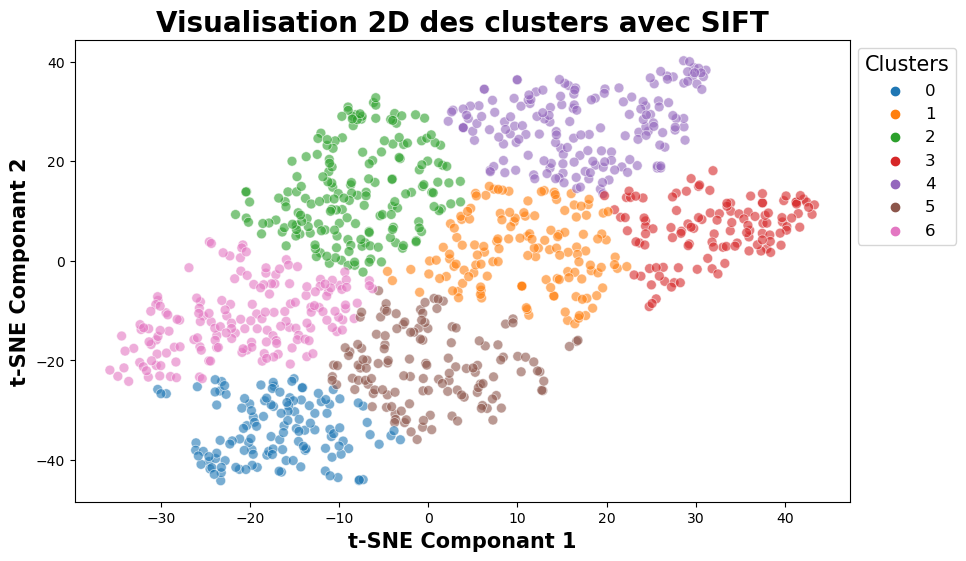

In [32]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Setting the details
plt.title('Visualisation 2D des clusters avec SIFT', fontsize=20, fontweight='bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Clusters', title_fontsize = 15)

# Displaying the plot
plt.show()

In [33]:
# Calculate Adjusted Rand Index (ARI)
labels = df["category_encoded"]
ari = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI: ", ari)

ARI:  -0.0003226667762712493


### CNN (Réseau neuronal convolutif) non supervisé

In [34]:
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation

In [35]:
img_height = 224
img_width = 224
#echantillonnage
df_samp = df.sample(500)
df_tsne0 = df_tsne.sample(500)
labels_samp = df["category_encoded"].sample(500)

### Transfert learning

In [36]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
image_path_cnn = 'Images/'

# Extract features from the images
def extract_features(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Use preprocess_input from tensorflow.keras.applications.vgg16
    features = vgg_model.predict(img)
    return features.flatten()

# Extract features from the images in your dataset
image_features = []
for image_filename in df_samp['image']:
    image_path = os.path.join(image_path_cnn, image_filename)
    features = extract_features(image_path)
    image_features.append(features)


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


In [55]:
# Converting the features list to an array
image_features = np.array(image_features)

# Performing a t-SNE to visualize the extracted features
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(image_features)

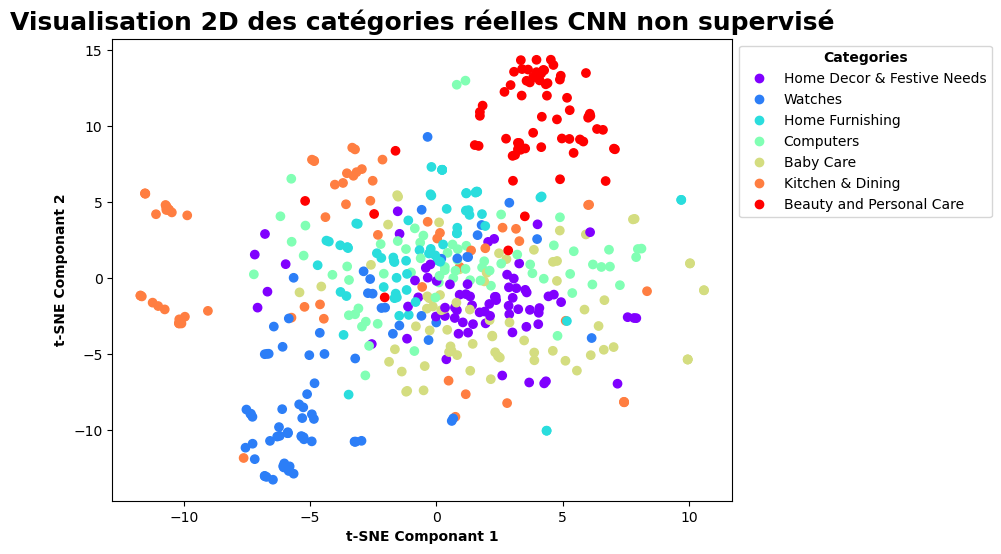

In [56]:
# Visualisation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=df_samp['category_encoded'], cmap = 'rainbow')
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_samp['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

plt.title('Visualisation 2D des catégories réelles CNN non supervisé', fontsize = 18, fontweight = 'bold')
plt.xlabel('t-SNE Componant 1', fontweight = 'bold')
plt.ylabel('t-SNE Componant 2', fontweight = 'bold')
plt.show()

In [57]:
# Performing the K-means clustering
cls0 = cluster.KMeans(n_clusters=7, random_state=6)
cls0.fit(tsne_features)

# Adding the cluster labels to the DataFrame

df_tsne0["cluster2"] = cls0.labels_
# Printing the shape of the Datdf_tsne0 = df_tsne.sample(500)aFrame
print(df_tsne0.shape)

(500, 5)


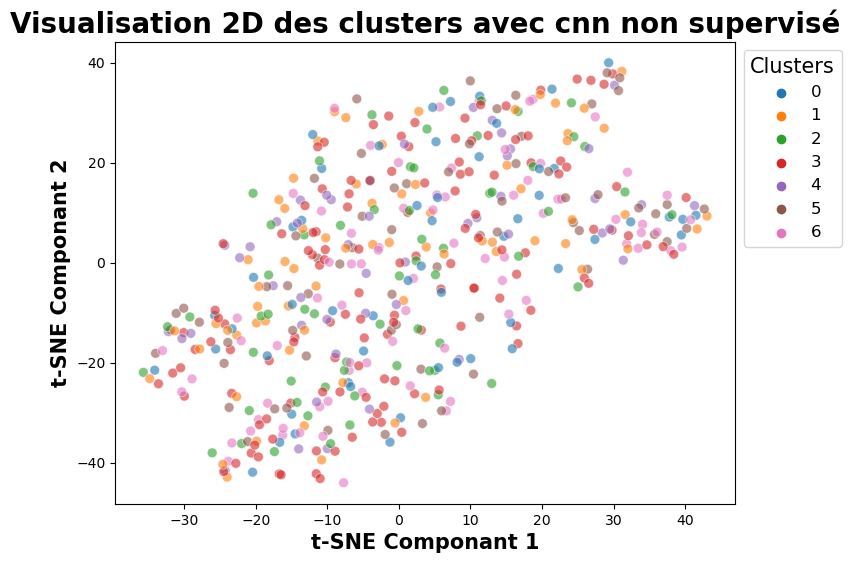

In [58]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_tsne0["tsne1"], y=df_tsne0["tsne2"],
    hue=cls0.labels_,
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne0,
    legend="brief")

# Setting the details
plt.title('Visualisation 2D des clusters avec cnn non supervisé', fontsize=20, fontweight='bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Clusters', title_fontsize = 15)

# Displaying the plot
plt.show()

In [59]:
ari = metrics.adjusted_rand_score(labels_samp, cls0.labels_)
print("ARI: ", ari)

ARI:  0.001772638034750292


### Réseau neuronal convolutif (CNN) supervisé

In [60]:
df_cnn = df[['image', 'category']]

### Modèle d’apprentissage profond avec Tensorflow et Keras

In [61]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(df):
    # Définir le chemin d'accès relatif aux images
    base_image_path = "Images"

    prepared_images = []
    for image_name in df['image']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)

        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


In [63]:
from sklearn.preprocessing import LabelEncoder
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()
# Convertir les labels texte en labels numériques
y_encoded = label_encoder.fit_transform(df['category'])
# Conversion des labels numériques en one-hot encoding
y = to_categorical(y_encoded)

In [64]:
from sklearn.model_selection import train_test_split
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [65]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping



model_l = Sequential()
model_l.add(Flatten(input_shape=(224, 224, 3))) # Convertir les images 2D en vecteur 1D
model_l.add(Dense(128, activation='relu'))
model_l.add(Dense(64, activation='relu'))
model_l.add(Dense(7, activation='softmax')) # 7 classes, donc 7 neurones en sortie

model_l.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_l.summary()

# Initialisation de l'arrêt anticipé
ant_arret = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Enregistrement du temps de début
time_0 = time.time()

pred = model_l.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[ant_arret])

# Enregistrement du temps de fin
time_1 = time.time()

# Calculer et afficher le temps écoulé
t_time = time_1 - time_0
print("")
print(f"Temps écoulé pour l'entraînement: {t_time:.2f} secondes")

# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model_l.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss:.4f}, test_accuracy = {test_accuracy:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 19,276,423
Trainable params: 19,276,423
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 7s 301ms/step - loss: 10665.3262 - accuracy: 0.1973 - val_loss: 4729.3130 - val_accuracy: 0.2930
Epoch 2/10
23/23 [=======

In [66]:
features_0 = model_l.predict(X)

33/33 [==============================] - 2s 58ms/step


In [68]:
image_features_0 = np.array(features_0)

# Performing a t-SNE to visualize the extracted features
tsne = TSNE(n_components=2, random_state=42)
tsne_features_0 = tsne.fit_transform(image_features_0)

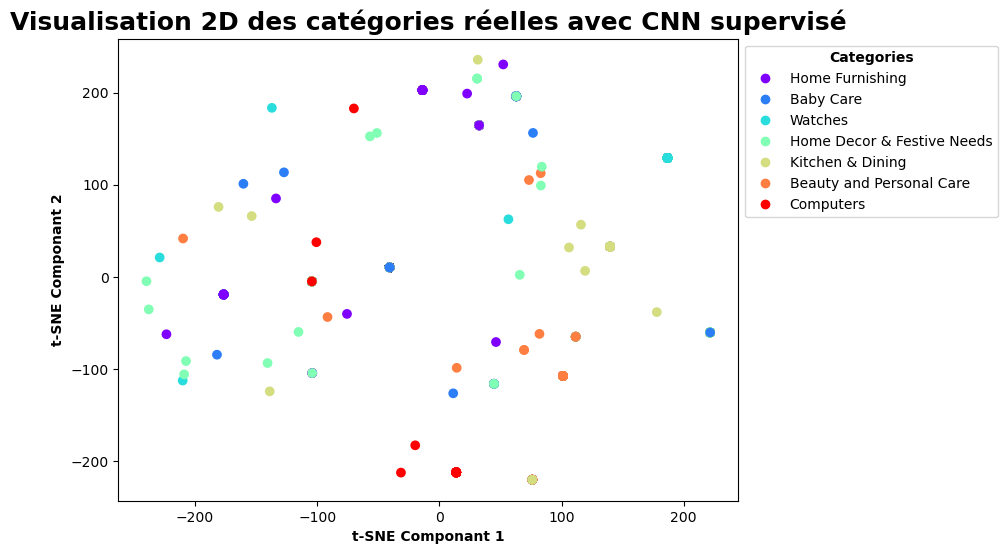

In [69]:
# visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_features_0[:, 0], tsne_features_0[:, 1], c=df['category_encoded'], cmap = 'rainbow')

# Adding legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details
plt.title('Visualisation 2D des catégories réelles avec CNN supervisé', fontsize = 18, fontweight = 'bold')
plt.xlabel('t-SNE Componant 1', fontweight = 'bold')
plt.ylabel('t-SNE Componant 2', fontweight = 'bold')
plt.show()

In [71]:
# Performing the K-means clustering
cls_cnn_sup = cluster.KMeans(n_clusters=7, random_state=6)
cls_cnn_sup.fit(tsne_features_0)
# Adding cluster_cnn_sup to the DataFrame
df_tsne["cluster_cnn_sup"] = cls_cnn_sup.labels_
print(df_tsne.shape)

(1050, 5)


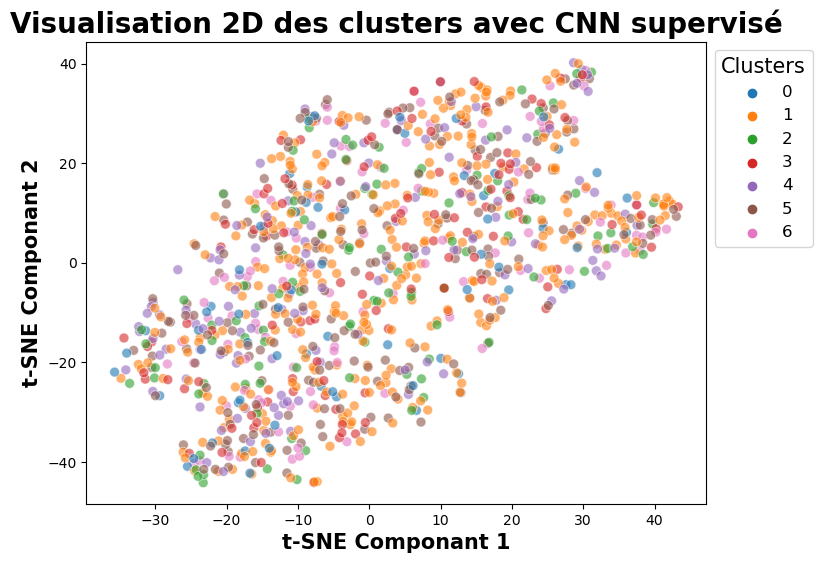

In [72]:
# visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_tsne["tsne1"], y=df_tsne["tsne2"],
    hue=cls_cnn_sup.labels_,
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Setting the details
plt.title('Visualisation 2D des clusters avec CNN supervisé', fontsize=20, fontweight='bold')
plt.xlabel('t-SNE Componant 1', fontsize=15, fontweight='bold')
plt.ylabel('t-SNE Componant 2', fontsize=15, fontweight='bold')
plt.legend(fontsize = 12, loc='upper left', bbox_to_anchor=(1, 1), title = 'Clusters', title_fontsize = 15)

# Displaying the plot
plt.show()

In [73]:
# Calculate Adjusted Rand Index (ARI)
labels = df["category_encoded"]
ari = metrics.adjusted_rand_score(labels, cls_cnn_sup.labels_)
print("ARI: ", ari)

ARI:  0.17605720589345825
